**Inhalt:** Selbständige Übung in Gruppen

**Nötige Skills:** Time Series

**Lernziele:**
- Selbständig Daten explorieren und Storyideen testen

# Das Beispiel

Covid-Daten aus den Schweizer Kantonen.

- Auswertung einzeln bzw. anhand von Gruppen
- Generierung von Story-Ideen und Plotten

Die Daten stammen von dieser Quelle: https://github.com/openZH/covid_19

# Vorbereitung

In [1]:
import pandas as pd

In [2]:
import numpy as np

## Daten laden

### 1. Fallzahlen

Wir können die Daten direkt von Github beziehen

In [4]:
path = 'https://github.com/openZH/covid_19/raw/master/COVID19_Fallzahlen_CH_total_v2.csv'

In [5]:
df = pd.read_csv(path)

In [6]:
df.head(5)

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
0,2020-01-01,00:00,GE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,0.0,0.0,0.0,NaN
1,2020-01-02,00:00,GE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,0.0,0.0,0.0,NaN
2,2020-01-03,00:00,GE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,0.0,0.0,0.0,NaN
3,2020-01-04,00:00,GE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,0.0,0.0,0.0,NaN
4,2020-01-05,00:00,GE,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0.0,https://infocovid.smc.unige.ch/,0.0,0.0,0.0,NaN


In [7]:
df.tail()

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
14524,2021-10-01,10:30,BS,NaN,16144.0,NaN,20.0,8.0,NaN,15725.0,213.0,https://www.gesundheit.bs.ch,206.0,147.0,NaN,NaN
14525,2021-10-01,12:00,AI,NaN,1728.0,NaN,NaN,NaN,NaN,NaN,17.0,https://www.ai.ch/themen/gesundheit-alter-und-...,32.0,9.0,NaN,NaN
14526,2021-10-01,14:30,ZH,NaN,139210.0,NaN,108.0,40.0,32.0,NaN,1477.0,https://www.zh.ch/de/gesundheit/coronavirus.html,1740.0,7410.0,NaN,NaN
14527,2021-10-02,00:00,GE,NaN,67617.0,NaN,NaN,NaN,NaN,NaN,748.0,https://infocovid.smc.unige.ch/,NaN,NaN,NaN,NaN
14528,2021-10-02,09:00,SZ,NaN,15478.0,NaN,NaN,NaN,NaN,14707.0,248.0,https://www.sz.ch/behoerden/information-medien...,NaN,NaN,NaN,NaN


### 2. Hilfsdaten zu Kantonen

Vorbereitetes File mit einigen Angaben, die wir nutzen können

In [8]:
df_c = pd.read_excel('dataprojects/Covid/cantons.xlsx')

In [9]:
df_c['bevölkerung'] = df_c['bevölkerung'].astype(int)

In [10]:
df_c.head()

,kanton,name,bevölkerung,grossregion
0,AG,Aargau,678207,Nordwestschweiz
1,AI,Appenzell IR,16145,Ostschweiz
2,AR,Appenzell AR,55234,Ostschweiz
3,BE,Bern,1034977,Mittelland
4,BL,Baselland,288132,Nordwestschweiz


# Daten checken

In [11]:
df.dtypes

date                                   object
time                                   object
abbreviation_canton_and_fl             object
ncumul_tested                         float64
ncumul_conf                           float64
new_hosp                              float64
current_hosp                          float64
current_icu                           float64
current_vent                          float64
ncumul_released                       float64
ncumul_deceased                       float64
source                                 object
current_isolated                      float64
current_quarantined                   float64
current_quarantined_riskareatravel    float64
current_quarantined_total             float64
dtype: object

In [12]:
df.shape

(14529, 16)

# Daten arrangieren

Unser Ziel sind zwei Dataframes:
- eines mit den kumulierten Fallzahlen (das sind die Werte, die wir in der Spalte "ncumul_conf" erhalten): `df_kum`
- eines mit der täglichen Indizenz (das müssen wir erst noch berechnen): `df_inz`

Wir wollen beide Dataframes im "wide"-Format haben. Das heisst:
- Die Indexspalte enthält das Datum (für jeden Tag genau eine Zeile)
- Die Kantone sind auf die restlichen Spalten aufgeteilt (AG, AI, AR, ...)

Um an diesen Punkt zu kommen, brauchen wir die Funktion `pivot()`. Sie erfordert drei Angaben:
- `index`: Aus welcher Spalte des originalen DF sollen die **Indexwerte** des neuen DF gebildet werden?
- `columns`: Aus welcher Spalte des orignalen DF sollen die **Spalten** des neuen DF gebildet werden?
- `values`: Aus welcher Spalte des orignalen DF sollen die **Werte** des neuen DF gebildet werden?

In [13]:
df_kum = df.pivot(index='date', columns='abbreviation_canton_and_fl', values='ncumul_conf')

In [14]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_kum.tail()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2021-09-28,59043.0,1711.0,NaN,79705.0,22690.0,16106.0,3447.0,NaN,67483.0,4035.0,...,6144.0,22710.0,15291.0,24879.0,36016.0,3828.0,NaN,42564.0,10319.0,138477.0
2021-09-29,59096.0,1714.0,NaN,79830.0,22723.0,16116.0,3447.0,NaN,67527.0,4043.0,...,6150.0,22736.0,15353.0,24927.0,36036.0,3844.0,NaN,42600.0,10348.0,138689.0
2021-09-30,59170.0,1723.0,NaN,79902.0,22750.0,16129.0,3448.0,NaN,67587.0,4053.0,...,6164.0,22752.0,15415.0,24965.0,36054.0,3859.0,NaN,42602.0,10374.0,138966.0
2021-10-01,NaN,1728.0,NaN,NaN,NaN,16144.0,3449.0,NaN,67615.0,4062.0,...,NaN,22772.0,15447.0,24965.0,36076.0,3870.0,NaN,NaN,10396.0,139210.0
2021-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67617.0,NaN,...,NaN,NaN,15478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nullen und NaNs

Ein Problem sind die NaNs - nicht für jeden Tag existiert eine Meldung aus jedem Kanton. Wir müssen die Leerstellen mit dem jeweils vorherigen Wert füllen. Dazu benutzen wir `.ffill()`

In [16]:
df_kum = df_kum.ffill()

In [17]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_kum.tail()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2021-09-28,59043.0,1711.0,2867.0,79705.0,22690.0,16106.0,3447.0,36368.0,67483.0,4035.0,...,6144.0,22710.0,15291.0,24879.0,36016.0,3828.0,94868.0,42564.0,10319.0,138477.0
2021-09-29,59096.0,1714.0,2867.0,79830.0,22723.0,16116.0,3447.0,36368.0,67527.0,4043.0,...,6150.0,22736.0,15353.0,24927.0,36036.0,3844.0,94868.0,42600.0,10348.0,138689.0
2021-09-30,59170.0,1723.0,2867.0,79902.0,22750.0,16129.0,3448.0,36368.0,67587.0,4053.0,...,6164.0,22752.0,15415.0,24965.0,36054.0,3859.0,94868.0,42602.0,10374.0,138966.0
2021-10-01,59170.0,1728.0,2867.0,79902.0,22750.0,16144.0,3449.0,36368.0,67615.0,4062.0,...,6164.0,22772.0,15447.0,24965.0,36076.0,3870.0,94868.0,42602.0,10396.0,139210.0
2021-10-02,59170.0,1728.0,2867.0,79902.0,22750.0,16144.0,3449.0,36368.0,67617.0,4062.0,...,6164.0,22772.0,15478.0,24965.0,36076.0,3870.0,94868.0,42602.0,10396.0,139210.0


Nächster Schritt: Die NaN am Anfang müssen durch Nullen ersetzt werden.

In [19]:
df_kum = df_kum.fillna(0).astype(int)

In [20]:
df_kum.head()

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0


### Indexspalte

Datentyp auf 'datetime':

In [21]:
df_kum.index = pd.to_datetime(df_kum.index)

... und noch etwas Verschönerung:

In [22]:
df_kum.index.name = None
df_kum.columns.name = None

### Inzidenzen

Um aus den kumulierten Fallzahlen die täglichen Inzidenzen zu erhalten, nutzen wir `diff()`

In [23]:
df_inz = df_kum.diff()

In [24]:
df_inz.head()

,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_inz.tail()

,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
2021-09-28,124.0,10.0,0.0,131.0,21.0,15.0,2.0,0.0,53.0,15.0,...,10.0,19.0,25.0,59.0,26.0,8.0,0.0,34.0,24.0,251.0
2021-09-29,53.0,3.0,0.0,125.0,33.0,10.0,0.0,0.0,44.0,8.0,...,6.0,26.0,62.0,48.0,20.0,16.0,0.0,36.0,29.0,212.0
2021-09-30,74.0,9.0,0.0,72.0,27.0,13.0,1.0,0.0,60.0,10.0,...,14.0,16.0,62.0,38.0,18.0,15.0,0.0,2.0,26.0,277.0
2021-10-01,0.0,5.0,0.0,0.0,0.0,15.0,1.0,0.0,28.0,9.0,...,0.0,20.0,32.0,0.0,22.0,11.0,0.0,0.0,22.0,244.0
2021-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fragestellung entwickeln

Viele verschiedene Auswertungen sind denkbar:
- verschiedene Zeitperioden vergleichen
- Inzidenz / totale Fallzahl
- verschiedene Kantone vergleichen
- verschiedene Grossregionen vergleichen
- Fallzahlen pro Kopf
- Fallzahlen im Wochen-/Monatsrhythmus
- Gleitender Durchschnitt
- ...

## Ein Beispiel

Grossregionen mit den Fallzahlen pro Kopf im 7-Tages-Durchschnitt
- Small Multiples
- Min-Max-Range mit Schnitt

**1. Fallzahlen zu Grossregionen aggregieren**

In [26]:
# Leeres DF, das die Inzidenzen für die Falzahlen enthalten wird
df_inz_reg = pd.DataFrame()

In [27]:
# Gruppierter Loop durch die Grossregionen => Summe der einzelnen Kantone wird zu neuer Spalte im neuen DF
for name, group in df_c.groupby('grossregion')['kanton']:
    df_inz_reg[name] = df_inz[group].sum(axis=1)

In [28]:
df_inz_reg

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-09-28,87.0,210.0,160.0,236.0,26.0,178.0,251.0
2021-09-29,80.0,181.0,96.0,195.0,20.0,198.0,212.0
2021-09-30,62.0,112.0,114.0,152.0,18.0,205.0,277.0
2021-10-01,28.0,23.0,15.0,39.0,22.0,90.0,244.0


**2. Fallzahlen pro Kopf**

In [29]:
# Bevölkerung für jede Grossregion Berechnen
reg_bev = df_c.groupby('grossregion')['bevölkerung'].sum()
reg_bev

grossregion
Genfersee          1642580
Mittelland         1877154
Nordwestschweiz    1161105
Ostschweiz         1176321
Tessin              353343
Zentralschweiz      813056
Zürich             1520968
Name: bevölkerung, dtype: int64

In [30]:
# Spalten durch Bevölkerungszahl dividieren (pro Million)
df_inz_reg_pc = df_inz_reg / reg_bev * 1000000
df_inz_reg_pc

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,2.435193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-09-28,52.965457,111.871482,137.799768,200.625510,73.582893,218.927110,165.026483
2021-09-29,48.703868,96.422563,82.679861,165.771078,56.602225,243.525661,139.384918
2021-09-30,37.745498,59.664790,98.182335,129.216430,50.942003,252.135154,182.120860
2021-10-01,17.046354,12.252591,12.918728,33.154216,62.262448,110.693482,160.424151


**3. Sieben-Tage-Schnitt**

In [31]:
# Gleitender Durchschnitt
df_inz_reg_pc_7d = df_inz_reg.rolling(7).mean()
df_inz_reg_pc_7d

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-09-28,102.000000,231.142857,136.714286,218.857143,20.142857,204.571429,241.142857
2021-09-29,93.000000,209.714286,130.285714,212.000000,19.285714,195.428571,217.285714
2021-09-30,87.714286,191.285714,121.571429,197.428571,16.714286,189.000000,211.428571
2021-10-01,77.000000,155.142857,100.428571,166.571429,17.714286,170.428571,210.857143


**4. Ungültige Zeilen entfernen**

Die ersten 7 Zeilen (wegen dem gleitenden Schnitt) und die letzten 2 Zeilen (wegen unvöllständigen Meldungen) müssen weg

In [32]:
df_inz_reg_pc_7d = df_inz_reg_pc_7d.iloc[7:-2]
df_inz_reg_pc_7d

,Genfersee,Mittelland,Nordwestschweiz,Ostschweiz,Tessin,Zentralschweiz,Zürich
2020-01-08,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-09,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-10,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-11,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-09-26,107.428571,259.571429,136.857143,236.142857,22.857143,200.142857,253.571429
2021-09-27,109.000000,247.714286,140.714286,227.571429,20.285714,210.285714,250.000000
2021-09-28,102.000000,231.142857,136.714286,218.857143,20.142857,204.571429,241.142857
2021-09-29,93.000000,209.714286,130.285714,212.000000,19.285714,195.428571,217.285714


**5. Plots**

- Small Multiples

In [33]:
import matplotlib.dates as mdates

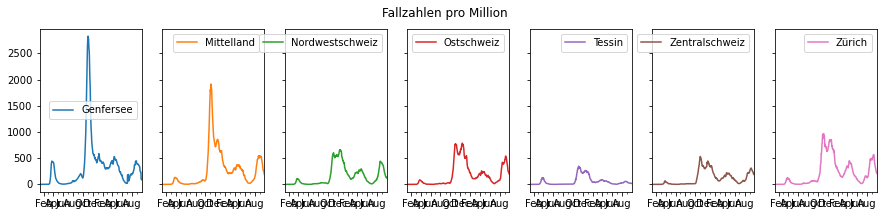

In [34]:
axes = df_inz_reg_pc_7d.plot(subplots=True, layout=(1,7), sharey=True, figsize=(15,3), title="Fallzahlen pro Million")
axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

- Fill between: Median der Kantone, höchster und tiefster Kanton

In [36]:
import matplotlib.pyplot as plt

In [37]:
x_values = df_inz_reg_pc_7d.index
y_mins = df_inz_reg_pc_7d.min(axis=1)
y_maxes = df_inz_reg_pc_7d.max(axis=1)
y_median = df_inz_reg_pc_7d.median(axis=1)

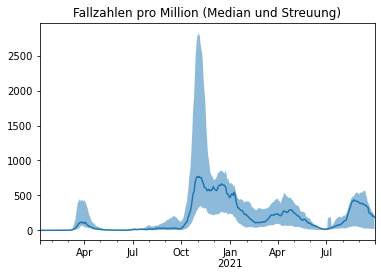

In [38]:
y_median.plot(figsize=(6,4), title='Fallzahlen pro Million (Median und Streuung)')
plt.fill_between(x_values, y_mins, y_maxes, alpha=0.5)